# Dehergne repertoire analysis

> First time use: follow instructions in the [README.md](README.md) file in this directory.

## Check version of timelink

If the cell bellow updates timelink a Restart of the notebook is needed (click Restart in the bar on top of this window)

In [2]:
%%capture
%pip install --upgrade timelink

## Extensions for this notebook 
(to later migrate to timelink-py)

In [3]:

from datetime import datetime
import pandas as pd

def convert_timelink_date(tl_date: str, format='%Y%m%d') -> datetime:
    """Convert a Timelink date in the format YYYYMMDD to a Python datetime

    Args:
    tl_date: a string representing a date in the format YYYYMMDD
    format: the format used to scan the date string
    Dates can be incomplete: 1586 or 1586-03 or 158603

    Zeros can be used to register unknown values: 15860000 or 15860300

    Missing information is handled in the following way:
    * If the year is missing returns None
    * If the month is missing, returns the 2nd of July of that year (middle day of the year)
    * If the day is missing, returns the 15th of the month (middle day of the month)
            """
    # return None if tl_date is None
    if tl_date is None:
        return None
    # if tl_date is not a string, return None
    if not isinstance(tl_date, str):
        return None
    # remove dashes
    tl_date_clean = tl_date.replace('-','')
    # pad tl_date with zeros up to length 8
    tl_date_clean = tl_date_clean.ljust(8,'0')
    year, month, day = tl_date_clean[:4], tl_date_clean[4:6], tl_date_clean[6:]
    # handle the case where month is zero by setting the month to 07 and day to 02 (middle day of year)
    if year == '0000':
        return None
    elif month == '00':
        month = '07'
        day = '02'
    elif day == '00':
        day = '15'

    new_date = year + month + day
    try:
        result = datetime.strptime(new_date, format)
    except ValueError as BadDate:
        print(tl_date, tl_date_clean)
        print(BadDate)
        result=None
    return result

def calc_age_at(date_birth, today):
    """Compute the number of years between two dates"""
    # return None if either argument is None
    if date_birth is None or today is None:
        return None
    # Ensure the dates are datetime objects
    if not isinstance(date_birth, datetime):
        date_birth = convert_timelink_date(date_birth)
    if not isinstance(today, datetime):
        today = convert_timelink_date(today)

    if date_birth is None or today is None:
        return None

    # Compute the difference in years
    difference_in_years = (today - date_birth).days / 365.25
    return int(difference_in_years)

def format_timelink_date(tl_datet)->str:
    """ Format a timelink date with format YYYYMMDD and variantes to nice string"""
    # return empty string if tl_datet is None
    if tl_datet is None:
        return ''
    # return empty string if tl_datet is not a string
    if not isinstance(tl_datet, str):
        return ''
    # fill with zeros
    tl_datet = tl_datet.ljust(8,'0')
    # if tl_datet is '00000000' return empty string
    if tl_datet == '00000000':
        return ''
    # if date ends in '0000' return just the first 4 characters
    if tl_datet.endswith('0000'):
        return tl_datet[:4]
    # if date ends in '00' return the first 6 characters with an hifen between 4th and 5th characters
    if tl_datet.endswith('00'):
        return tl_datet[:4] + '-' + tl_datet[4:6]
    # Otherwise convert the date
    py_date = convert_timelink_date(tl_datet)
    if py_date is None:
        return ''
    # return date in format YYYY-MM-DD
    return py_date.strftime('%Y-%m-%d')

print("testing")
print(format_timelink_date('00000000'))
print(format_timelink_date(None))
print(format_timelink_date('1582'))
print(format_timelink_date('158203'))
print(format_timelink_date('1582-03-02'))
print(format_timelink_date('15820302'))
print(calc_age_at('1980-01-01', '2020-01-01'))
print(calc_age_at('1980-01-01', 0))

testing


1582
1582-03
1582-03-02
1582-03-02
40
None


## Initial setup

Create a TimelinkNotebook object. This will be the interface for most of your interactions with Timelink.

The first time you run this notebook, you will be prompted to install ìpykernel. This is required to run Timelink in a notebook.

Note:
* First time run takes a little time as the required Docker images are downloaded.
* Timelink will default to using sqlite as the database, see [Receipts notebook for more control](1-receipts.ipynb)


In [4]:
from timelink.notebooks import TimelinkNotebook

tlnb = TimelinkNotebook(db_type='sqlite')
tlnb.print_info(show_token=True)

Timelink version: 1.1.10
Project name: dehergne-locations
Project home: /Users/jrc/mhk-home/sources/dehergne-locations
Database type: sqlite
Database name: dehergne_locations
Kleio image: timelinkserver/kleio-server
Kleio server token: r9dGv8RTbqOcWUrP34a52jSXr6Evtjz3
Kleio server URL: http://127.0.0.1:8088
Kleio server home: /Users/jrc/mhk-home/sources/dehergne-locations
Kleio server container: brave_cannon
Kleio version requested: latest
Kleio server version: 12.5.570 (2024-02-29 07:39:03)
SQLite directory: /Users/jrc/mhk-home/sources/dehergne-locations/database/sqlite
Call print_info(show_password=True) to show the Postgres password
TimelinkNotebook(project_name=dehergne-locations, project_home=/Users/jrc/mhk-home/sources/dehergne-locations, db_type=sqlite, db_name=dehergne_locations, kleio_image=timelinkserver/kleio-server, kleio_version=latest, postgres_image=postgres, postgres_version=latest)


### Database status

Count the number of rows in each table in the database.


In [5]:
tlnb.table_row_count_df()

,table,count
0,acts,29
1,aregisters,1
2,attributes,26063
3,class_attributes,70
4,classes,14
5,entities,32220
6,geoentities,359
7,goods,0
8,kleiofiles,31
9,objects,0


## Check the status of the files

Check the import status of the translated files

* I: Imported
* E: Imported with error
* W: Imported with warnings no errors
* N: Not imported
* U: Translation updated need to reimport

In [6]:
kleio_files = tlnb.get_kleio_files()
# kleio_files.info()
kleio_files[["name","import_status","status","errors","warnings","imported","import_errors","import_warnings"]]

,name,import_status,status,errors,warnings,imported,import_errors,import_warnings
0,dehergne-0-abrev.cli,I,V,0,0,2024-05-30 13:11:52.698545,0,0
1,dehergne-a.cli,I,V,0,0,2024-06-01 06:14:24.623391,0,0
2,dehergne-b.cli,I,V,0,0,2024-05-31 07:14:02.281938,0,0
3,dehergne-c.cli,I,V,0,0,2024-05-31 07:24:00.842583,0,0
4,dehergne-d.cli,I,V,0,0,2024-05-31 07:14:16.822487,0,0
5,dehergne-e.cli,I,V,0,0,2024-05-30 13:12:22.236161,0,0
6,dehergne-f.cli,I,V,0,0,2024-05-31 07:14:23.426420,0,0
7,dehergne-g.cli,I,V,0,0,2024-06-01 06:14:31.574148,0,0
8,dehergne-h.cli,I,V,0,0,2024-05-30 13:12:37.569205,0,0
9,dehergne-i.cli,I,V,0,0,2024-05-31 07:14:31.415438,0,0


List files with import errors

In [7]:
eids = kleio_files[kleio_files["import_status"]=='E'].index
print(eids)
rpt = tlnb.get_import_rpt(kleio_files,rows=list(eids))
print(rpt)

Index([], dtype='int64')




## Update the database from Kleio sources.

Updates source translations and imports into database sources with no errors.

Only changed files since last import, or new files, will be processed.

When importing to an empty database some errors can be generated
if some files contain "xsame_as/xmesmo_que" links to other files
not yet imported.

This is solved by reimporting the files in error after the first import, so that the cross references are solved. Ensure that
that `update_from_sources` is called with ``with_import_errors=True``.

It may be necessary a third import run
to solve all cross references.

In [8]:
import logging
logging.basicConfig(level=logging.INFO)

tlnb.update_from_sources(with_import_errors=True)

## Nacionality / Nacionalidades

In [9]:
import pandas as pd
from timelink.pandas import attribute_values
# set max rows to 500
pd.set_option('display.max_rows', 500)

df_totals = attribute_values('nacionalidade',db=tlnb.db)
df_totals

,count,date_min,date_max
value,,,
Portugal,431,0,0
França,184,0,0
China,177,0,0
Itália,125,0,19730000
Espanha,43,0,0
Alemanha,36,0,0
Bélgica,23,0,0
Áustria,15,0,0
Flandres,12,0,0


### List of all with attribute "nacionalidade"

In [10]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

nacionais = entities_with_attribute(
    entity_type='person',
    show_elements=['id','name','groupname'],
    the_type='nacionalidade',
    more_attributes=['nascimento'],
    db=tlnb.db,
)
# filter groupname = 'n' (avoid "referido", "pai", "mãe")
nacionais = nacionais[nacionais.groupname=='n']
nacionais.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, deh-hermann-engers to deh-alessandro-valignano
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id_1                 942 non-null    object
 1   name                 942 non-null    object
 2   groupname            942 non-null    object
 3   nacionalidade.type   942 non-null    object
 4   nacionalidade        942 non-null    object
 5   nacionalidade.date   942 non-null    object
 6   nacionalidade.line   942 non-null    int64 
 7   nacionalidade.level  942 non-null    int64 
 8   nacionalidade.obs    942 non-null    object
 9   nascimento           854 non-null    object
 10  nascimento.date      854 non-null    object
 11  nascimento.obs       854 non-null    object
dtypes: int64(2), object(10)
memory usage: 95.7+ KB


### Export all with attribute "nacionalidade"

In [11]:
nacionais.to_excel("paises_pessoas_n.xlsx", sheet_name='Sheet1', index=False)

### Group by nacionalidade

In [12]:
paises_totais=nacionais.groupby('nacionalidade')['id_1'].nunique().reset_index().sort_values('id_1',ascending=False)
paises_totais

,nacionalidade,id_1
19,Portugal,346
10,França,168
4,China,146
14,Itália,113
0,Alemanha,35
7,Espanha,34
3,Bélgica,22
24,Áustria,14
9,Flandres,11
2,Boémia,10


In [13]:
paises_totais.to_excel("paises_totais_n.xlsx", sheet_name='Sheet1', index=False)

### Countries and evolution of departures

In [14]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

embarques = entities_with_attribute(
    entity_type='person',
    show_elements=['id','name','groupname'],
    the_type='nacionalidade',
    more_attributes=['wicky'],
    db=tlnb.db,
)
# filter groupname = 'n' (avoid "referido", "pai", "mãe")
embarques = embarques[embarques.groupname=='n']
embarques['wicky.date'] = embarques['wicky.date'].fillna('0000')
embarques.info()
cols =['name','nacionalidade','wicky.date']
# replace NaN in wicky.date with 0000

embarques[cols].sort_values('wicky.date').head()

<class 'pandas.core.frame.DataFrame'>
Index: 987 entries, aloys-moriz to joao-cardoso
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id_1                 987 non-null    object
 1   name                 987 non-null    object
 2   groupname            987 non-null    object
 3   nacionalidade.type   987 non-null    object
 4   nacionalidade        987 non-null    object
 5   nacionalidade.date   987 non-null    object
 6   nacionalidade.line   987 non-null    int64 
 7   nacionalidade.level  987 non-null    int64 
 8   nacionalidade.obs    987 non-null    object
 9   wicky                529 non-null    object
 10  wicky.date           987 non-null    object
 11  wicky.obs            529 non-null    object
dtypes: int64(2), object(10)
memory usage: 100.2+ KB


,name,nacionalidade,wicky.date
id,,,
aloys-moriz,Aloys Moriz,Áustria,0000
deh-joao-da-fonseca-i,João da Fonseca,Portugal,0000
deh-joao-da-silva,João da Silva,Portugal,0000
deh-joao-de-borgia-kouo,João de Borgia Kouo,Portugal,0000
deh-joao-de-sa,João de Sá,Portugal,0000


#### Group by country decade

In [15]:
# extract the year from wicky.date
embarques['ano_embarque'] = embarques['wicky.date'].str[:4]
# convert 'ano_entrada' to integer
embarques['ano_embarque'] = embarques['ano_embarque'].astype(int)
# count ano_entrada per periods of 10 years starting from 1540
embarques['periodo_embarque'] = embarques['ano_embarque'] // 10 * 10
# show columns jesuita-entrada.date, ano_entrada, periodo
embarques[['wicky.date','ano_embarque','periodo_embarque']].sort_values('wicky.date').tail(10)
# count number of embarques per period
embarques.groupby(['nacionalidade','periodo_embarque',])['id_1'].count().reset_index().sort_values(['nacionalidade','periodo_embarque',])


,nacionalidade,periodo_embarque,id_1
0,Alemanha,0,7
1,Alemanha,1610,3
2,Alemanha,1630,1
3,Alemanha,1650,3
4,Alemanha,1680,2
5,Alemanha,1690,6
6,Alemanha,1700,3
7,Alemanha,1710,4
8,Alemanha,1730,5
9,Alemanha,1740,1


### Countries and place of entry / Países e locais de entrada

In [16]:

import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

nacionalidade_entrada = entities_with_attribute(
    entity_type='person',
    show_elements=['id','name','groupname'],
    the_type='nacionalidade',
    more_attributes=['nascimento', 'jesuita-entrada','jesuita-entrada-x'],
    db=tlnb.db,
)
# filter groupname = 'n' (avoid "referido", "pai", "mãe")
nacionalidade_entrada = nacionalidade_entrada[nacionalidade_entrada.groupname=='n']
nacionalidade_entrada['jesuita-entrada'] = nacionalidade_entrada['jesuita-entrada'].fillna('?')
nacionalidade_entrada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949 entries, aloys-moriz to joao-cardoso
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_1                  949 non-null    object
 1   name                  949 non-null    object
 2   groupname             949 non-null    object
 3   nacionalidade.type    949 non-null    object
 4   nacionalidade         949 non-null    object
 5   nacionalidade.date    949 non-null    object
 6   nacionalidade.line    949 non-null    int64 
 7   nacionalidade.level   949 non-null    int64 
 8   nacionalidade.obs     949 non-null    object
 9   nascimento            861 non-null    object
 10  nascimento.date       861 non-null    object
 11  nascimento.obs        861 non-null    object
 12  jesuita-entrada       949 non-null    object
 13  jesuita-entrada.date  845 non-null    object
 14  jesuita-entrada.obs   845 non-null    object
 15  jesuita-entrada-x     0 no

In [17]:
nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique()
df = nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique().reset_index()
df_subtotal = df.groupby('nacionalidade')['id_1'].sum().reset_index()
df_subtotal.columns = ['nacionalidade', 'subtotal']
df = pd.merge(df, df_subtotal, on='nacionalidade')
df['perc_nacionalidade'] = df['id_1']/df['subtotal']
df.sort_values(['subtotal','nacionalidade','id_1'], ascending=[False,True,False])


,nacionalidade,jesuita-entrada,id_1,subtotal,perc_nacionalidade
99,Portugal,?,204,347,0.587896
100,Portugal,Coimbra,56,347,0.161383
103,Portugal,Lisboa,37,347,0.106628
107,Portugal,Évora,22,347,0.063401
101,Portugal,Goa,20,347,0.057637
104,Portugal,Macau,3,347,0.008646
102,Portugal,Japão,2,347,0.005764
105,Portugal,Ormuz,1,347,0.002882
106,Portugal,Portugal,1,347,0.002882
108,Portugal,Índia,1,347,0.002882


In [18]:
df = nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique().reset_index()
df_subtotal = df.groupby('nacionalidade')['id_1'].sum().reset_index()
df_subtotal.columns = ['nacionalidade', 'subtotal']
df = pd.merge(df, df_subtotal, on='nacionalidade')
df['perc_nacionalidade'] = df['id_1']/df['subtotal']
df

,nacionalidade,jesuita-entrada,id_1,subtotal,perc_nacionalidade
0,Alemanha,?,15,35,0.428571
1,Alemanha,Brno,2,35,0.057143
2,Alemanha,Landsberg,7,35,0.200000
3,Alemanha,Mainz,1,35,0.028571
4,Alemanha,Polotsk,1,35,0.028571
5,Alemanha,Portugal,1,35,0.028571
6,Alemanha,Roma,3,35,0.085714
7,Alemanha,Trier,3,35,0.085714
8,Alemanha,Viena,2,35,0.057143
9,Alsácia,Landsberg,1,2,0.500000


## Jesuit Entry (jesuita-entrada)

The attribute `jesuita-entrada` records the jesuit college/noviciate
where the future missionary enrolled in the Society of Jesus.

Note that a few entries have more than one value for `jesuita-entrada`
because the person dropped out after the first enrollement and later enrolled again.

### jesuita-entrada (totals)

In [19]:
import pandas as pd
from timelink.pandas import attribute_values
# set max rows to 500
pd.set_option('display.max_rows', 500)

df_totals = attribute_values('jesuita-entrada',db=tlnb.db)
df_totals.info()
df_totals['data_inicial'] = df_totals['date_min'].apply(format_timelink_date)
df_totals['data_final'] = df_totals['date_max'].apply(format_timelink_date)
# Extract the first 4 characters of data_inicial to get the year, store in column Ano_inicial
df_totals['Ano_inicial'] = df_totals['data_inicial'].str[:4]
# Extract the first 4 characters of data_final to get the year, store in column Ano_final
df_totals['Ano_final'] = df_totals['data_final'].str[:4]
df_totals

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, ? to Índia
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   count     67 non-null     int64 
 1   date_min  67 non-null     object
 2   date_max  67 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


,count,date_min,date_max,data_inicial,data_final,Ano_inicial,Ano_final
value,,,,,,,
?,486,15440000,17880828,1544,1788-08-28,1544,1788
Coimbra,58,15420000,17420427,1542,1742-04-27,1542,1742
Lisboa,45,15460000,17530612,1546,1753-06-12,1546,1753
Paris,41,16300108,17590310,1630-01-08,1759-03-10,1630,1759
Roma,40,15480311,17560709,1548-03-11,1756-07-09,1548,1756
Goa,33,15480000,17360000,1548,1736,1548,1736
Évora,26,15660714,17460405,1566-07-14,1746-04-05,1566,1746
Nancy,15,16270929,17510827,1627-09-29,1751-08-27,1627,1751
Landsberg,14,16230729,17571009,1623-07-29,1757-10-09,1623,1757


#### Export to Excel

In [20]:
df_totals.to_excel("jesuita-entrada_totals.xlsx", sheet_name='Sheet_name_1')

### All know places of entry (todos os lugares de entrada conhecidos)

In [21]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-entrada',
    more_attributes=['nacionalidade','nascimento'],
    db=tlnb.db,
)
jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['nacionalidade'] = jesuita_entrada_full['nacionalidade'].fillna('')
jesuita_entrada_full['name'] = jesuita_entrada_full['name'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['nacionalidade_sort'] = jesuita_entrada_full['nacionalidade'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)

# save those with jesuita-entrada not equal to '?'
# entrada_known = jesuita_entrada_full['jesuita-entrada'] != '?'
only_n = jesuita_entrada_full.fillna('').groupname == 'n'
jesuita_entrada_full = jesuita_entrada_full[only_n]
cols=['jesuita-entrada','jesuita-entrada.date','name','nacionalidade','nascimento','jesuita-entrada.obs']
# jesuita_entrada_full[(only_n) & (entrada_known)].sort_values(by=['jesuita-entrada','jesuita-entrada.date','name_sort','nascimento'])[cols].head(70)
jesuita_entrada_full.sort_values(by=['jesuita-entrada.date','jesuita-entrada','name_sort','nascimento'])[cols].head(70)



<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, aloys-moriz to joao-cardoso
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   963 non-null    object
 1   groupname              963 non-null    object
 2   jesuita-entrada.type   963 non-null    object
 3   jesuita-entrada        963 non-null    object
 4   jesuita-entrada.date   963 non-null    object
 5   jesuita-entrada.line   963 non-null    int64 
 6   jesuita-entrada.level  963 non-null    int64 
 7   jesuita-entrada.obs    963 non-null    object
 8   nacionalidade          920 non-null    object
 9   nacionalidade.date     920 non-null    object
 10  nacionalidade.obs      920 non-null    object
 11  nascimento             947 non-null    object
 12  nascimento.date        947 non-null    object
 13  nascimento.obs         947 non-null    object
dtypes: int64(2), object(12)
memory usage: 112.9+ KB


,jesuita-entrada,jesuita-entrada.date,name,nacionalidade,nascimento,jesuita-entrada.obs
id,,,,,,
deh-andre-fernandes-i,Ormuz,000000,André Fernandes,Portugal,Campo Maior,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pedro-de-alcacova,Coimbra,15420000,Pedro de Alcáçova,Portugal,?,"saiu a primeira vez extra_info: {""value"": {""co..."
deh-belchior-nunes-barreto,Coimbra,15430311,Belchior Nunes Barreto,Portugal,Porto,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-belchior-miguel-carneiro-leitao,Coimbra,15430425,Belchior Miguel Carneiro Leitão,Portugal,Coimbra,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-francisco-perez,Coimbra,15440125,Francisco Pérez,Espanha,"Villanueva de Barcarrota, diocese de Badajoz","extra_info: {""date"": {""comment"": ""j\u00e1 \u00..."
deh-tiburcio-de-quadros,Coimbra,15440418,Tibúrcio de Quadros,Portugal,Santarém,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-baltasar-gago,Lisboa,15460000,Baltasar Gago,Portugal,Lisboa,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pedro-riera,Roma,15480311,Pedro Riera,Espanha,Barcelona,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pedro-de-alcacova,Goa,15480502,Pedro de Alcáçova,Portugal,?,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."


#### Export to Excel

In [22]:
jesuita_entrada_full[cols].to_excel("jesuitas-entrada-full.xlsx", sheet_name='Sheet_name_1')

### Analyse trends in decades

In [23]:
# extract the year from jesuita-entrada.date
jesuita_entrada_full['ano_entrada'] = jesuita_entrada_full['jesuita-entrada.date'].str[:4]
# convert 'ano_entrada' to integer
jesuita_entrada_full['ano_entrada'] = jesuita_entrada_full['ano_entrada'].astype(int)
# count ano_entrada per periods of 10 years starting from 1540
jesuita_entrada_full['periodo_entrada'] = (jesuita_entrada_full['ano_entrada'] - 1540) // 10 * 10 + 1540
# show columns jesuita-entrada.date, ano_entrada, periodo
jesuita_entrada_full[['jesuita-entrada.date','ano_entrada','periodo_entrada']].sort_values('jesuita-entrada.date').head(10)


,jesuita-entrada.date,ano_entrada,periodo_entrada
id,,,
deh-andre-fernandes-i,000000,0,0
deh-pedro-de-alcacova,15420000,1542,1540
deh-belchior-nunes-barreto,15430311,1543,1540
deh-belchior-miguel-carneiro-leitao,15430425,1543,1540
deh-francisco-perez,15440125,1544,1540
deh-tiburcio-de-quadros,15440418,1544,1540
deh-baltasar-gago,15460000,1546,1540
deh-pedro-riera,15480311,1548,1540
deh-pedro-de-alcacova,15480502,1548,1540


In [24]:
# count number of jesuitas-entrada per period
jesuita_entrada_full.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')


,periodo_entrada,name
0,0,1
1,1540,12
2,1550,24
3,1560,16
4,1570,20
5,1580,28
6,1590,24
7,1600,33
8,1610,28
9,1620,42


#### Make a graph ignoring period < 1540


In [25]:
%pip install seaborn

.bash_profile RUN!
Note: you may need to restart the kernel to use updated packages.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


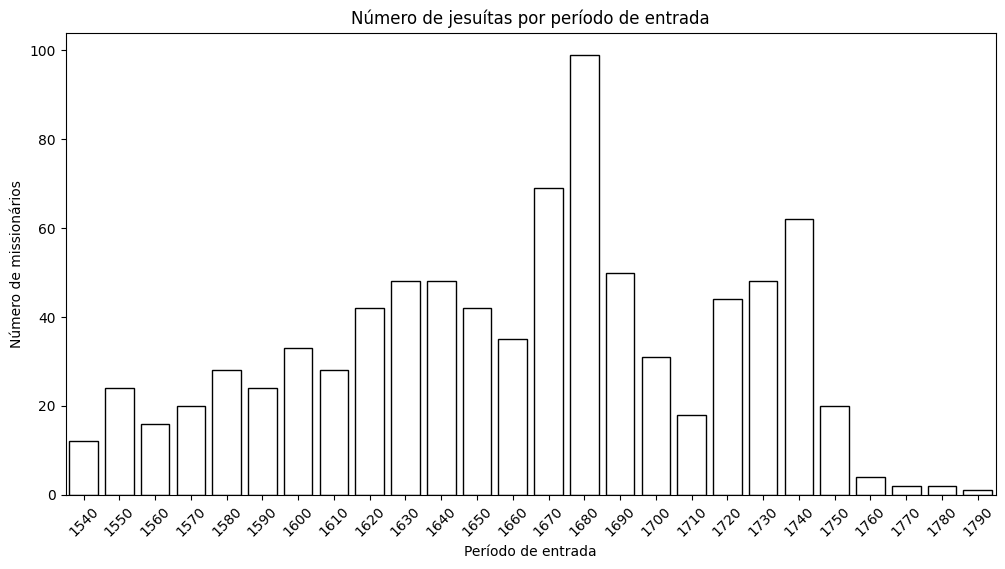

In [26]:
# make a chart of the number of jesuitas-entrada per period ignoring period < 1540
# Label the vertical axis as "Número de missionários"
# Label the horizontal axis as "Período de entrada"
import matplotlib.pyplot as plt
import seaborn as sns

# filter period >= 1540
df = jesuita_entrada_full[jesuita_entrada_full.periodo_entrada >= 1540]

# count number of jesuitas-entrada per period
df = df.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')

# create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='periodo_entrada', y='name', color='white', edgecolor='black')
plt.xticks(rotation=45)
plt.title('Número de jesuítas por período de entrada')

# Label the vertical axis
plt.ylabel('Número de missionários')

# Label the horizontal axis
plt.xlabel('Período de entrada')

plt.show()


### Place of entry "unkown" with country and place of birth

In [27]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-entrada',
    the_value='?',
    more_attributes=['nacionalidade','nascimento'],
    db=tlnb.db,
)
# filter by those with groupname = 'n' (avoid "referido", "pai", "mãe")
jesuita_entrada_full = jesuita_entrada_full[jesuita_entrada_full.groupname=='n']

jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['nacionalidade'] = jesuita_entrada_full['nacionalidade'].fillna('?')
jesuita_entrada_full['name'] = jesuita_entrada_full['name'].fillna('?')
jesuita_entrada_full['nascimento'] = jesuita_entrada_full['nascimento'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['nacionalidade_sort'] = jesuita_entrada_full['nacionalidade'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)

cols=['name','nacionalidade','nascimento','jesuita-entrada.date','jesuita-entrada','jesuita-entrada.obs']
jesuita_entrada_full[jesuita_entrada_full.groupname=='n'].sort_values(by=['nacionalidade_sort','name_sort','nascimento'])[cols].head(50)



<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, deh-adam-weidenfied to joao-cardoso
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   409 non-null    object
 1   groupname              409 non-null    object
 2   jesuita-entrada.type   409 non-null    object
 3   jesuita-entrada        409 non-null    object
 4   jesuita-entrada.date   409 non-null    object
 5   jesuita-entrada.line   409 non-null    int64 
 6   jesuita-entrada.level  409 non-null    int64 
 7   jesuita-entrada.obs    409 non-null    object
 8   nacionalidade          406 non-null    object
 9   nacionalidade.date     406 non-null    object
 10  nacionalidade.obs      406 non-null    object
 11  nascimento             404 non-null    object
 12  nascimento.date        404 non-null    object
 13  nascimento.obs         404 non-null    object
dtypes: int64(2), object(12)
memory usage: 47.9+ KB


,name,nacionalidade,nascimento,jesuita-entrada.date,jesuita-entrada,jesuita-entrada.obs
id,,,,,,
deh-bartolome-de-roboredo,Bartolomé de Roboredo,?,?,16460000,?,"extra_info: {""date"": {""comment"": ""volta a ser ..."
deh-herman-scolt,Herman Scolt,?,?,17281228,?,
deh-jacques-barthe,Jacques Barthe,?,?,16780000,?,
deh-adam-weidenfied,Adam Weidenfied,Alemanha,Colónia,16630412,?,
deh-anton-gogeisl,Anton Gogeisl,Alemanha,"Siegenburg, Baviera, diocese de Regensburg",17200913,?,
deh-bernhard-diestel,Bernhard Diestel,Alemanha,"Wippach, Carniole",16391022,?,
deh-christian-henricus,Christian Henricus,Alemanha,?,16420000,?,
deh-christof-brack,Christof Brack,Alemanha,"Diocese de Constance, Rottenburg am Neckar",16720716,?,
deh-franz-moser,Franz Moser,Alemanha,"Mauerkirchen, dicese de Passau",17321003,?,


#### Export to Excel

In [28]:
jesuita_entrada_full[cols].to_excel("jesuitas-entrada-desc.xlsx", sheet_name='Sheet_name_1')

#### Export to text file (Portugal)

In [29]:
# Get id of interest
country_of_interest = 'Portugal'
ids = jesuita_entrada_full[jesuita_entrada_full.nacionalidade==country_of_interest].index.unique()

tlnb.db.export_as_kleio(ids,f'jesuitas-entrada-desc-{country_of_interest}.txt')

##  Missionaries by specific place of entry in the Jesuit order

Obter os missionários por lugar de entrada na ordem


### Example/Exemplo: Coimbra

Showing palce of birth, embarque (departure).

In [30]:
place_of_entry = "Coimbra"

In [31]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

jesuita_entrada_embarque = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-entrada',
    the_value=place_of_entry,
    more_attributes=['dehergne','nascimento','embarque','morte'],
    db=tlnb.db,
)

# jesuita_entrada_embarque.info()

# user only group "n"
jesuita_entrada_embarque = jesuita_entrada_embarque[jesuita_entrada_embarque.groupname=='n']

# add age at 'jesuita-entrada.date'
jesuita_entrada_embarque['age_at_entrada'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['jesuita-entrada.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_entrada'] = jesuita_entrada_embarque['age_at_entrada'].astype('Int64')

# add age at 'embarque.date'
jesuita_entrada_embarque['age_at_embarque'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['embarque.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_embarque'] = jesuita_entrada_embarque['age_at_embarque'].astype('Int64')
# years between jesuita-entrada and embarque
jesuita_entrada_embarque['entrada_to_embarque'] = jesuita_entrada_embarque['age_at_embarque'] - jesuita_entrada_embarque['age_at_entrada']

# add age at 'morte.date'
jesuita_entrada_embarque['age_at_morte'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['morte.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_morte'] = jesuita_entrada_embarque['age_at_morte'].astype('Int64')

# time in missions
jesuita_entrada_embarque['mission_time'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['embarque.date'], x['morte.date']), axis=1)
# convert to int
jesuita_entrada_embarque['mission_time'] = jesuita_entrada_embarque['mission_time'].astype('Int64')


# format dates
jesuita_entrada_embarque['nascimento.date.formated'] = jesuita_entrada_embarque['nascimento.date'].apply(format_timelink_date)
# create column with year (first 4 characters of 'nascimento.date.formated')
jesuita_entrada_embarque['nascimento.date.year'] = jesuita_entrada_embarque['nascimento.date.formated'].str[:4]

jesuita_entrada_embarque['jesuita-entrada.date.formated'] = jesuita_entrada_embarque['jesuita-entrada.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['jesuita-entrada.date.year'] = jesuita_entrada_embarque['jesuita-entrada.date.formated'].str[:4]
jesuita_entrada_embarque['embarque.date.formated'] = jesuita_entrada_embarque['embarque.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['embarque.date.year'] = jesuita_entrada_embarque['embarque.date.formated'].str[:4]

jesuita_entrada_embarque['morte.date.formated'] = jesuita_entrada_embarque['morte.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['morte.date.year'] = jesuita_entrada_embarque['morte.date.formated'].str[:4]

cols=['dehergne','name','nascimento.date.year',
            'jesuita-entrada.date.year','jesuita-entrada','age_at_entrada','entrada_to_embarque',
            'embarque.date.year','age_at_embarque',
            'morte.date.year','age_at_morte','mission_time','morte']
# remove lines with duplicate values for column 'dehergne'
jesuita_entrada_embarque = jesuita_entrada_embarque.sort_values(by=['jesuita-entrada.date.formated','embarque.date.formated']).drop_duplicates(subset=['dehergne'])
jesuita_entrada_embarque.info()
jesuita_entrada_embarque.sort_values(by=['name','jesuita-entrada.date.formated','embarque.date.formated'])[cols]


<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, deh-pedro-de-alcacova to deh-inacio-pires
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   name                           57 non-null     object
 1   groupname                      57 non-null     object
 2   jesuita-entrada.type           57 non-null     object
 3   jesuita-entrada                57 non-null     object
 4   jesuita-entrada.date           57 non-null     object
 5   jesuita-entrada.line           57 non-null     int64 
 6   jesuita-entrada.level          57 non-null     int64 
 7   jesuita-entrada.obs            57 non-null     object
 8   dehergne                       57 non-null     object
 9   dehergne.date                  57 non-null     object
 10  dehergne.obs                   57 non-null     object
 11  nascimento                     57 non-null     object
 12  nascimento.date                57 non

,dehergne,name,nascimento.date.year,jesuita-entrada.date.year,jesuita-entrada,age_at_entrada,entrada_to_embarque,embarque.date.year,age_at_embarque,morte.date.year,age_at_morte,mission_time,morte
id,,,,,,,,,,,,,
deh-adriano-pestana,631,Adriano Pestana,1617,1635,Coimbra,17,8,1643,25,,<NA>,<NA>,NaN
deh-afonso-aires,10,Afonso Aires,1630,1649,Coimbra,19,7,1657,26,1657,27,0,"[No mar, depois do Cabo da Boa Esperança]"
deh-andre-carneiro,142,André Carneiro,1650,1664,Coimbra,13,31,1694,44,1709,58,14,Goa
deh-andre-ferrao,296,André Ferrão,1625,1640,Coimbra,15,16,1657,31,1661,36,4,"Foochow (Fou-tcheou fou, Fukien)"
deh-andre-palmeiro,606,André Palmeiro,1569,1584,Coimbra,14,33,1617,47,1635,65,17,Macau
deh-antao-dantas,235,Antão Dantas,1674,1693,Coimbra,18,1,1694,19,1721,46,26,Goa
deh-antonio-gomes,370,António Gomes,1706,1725,Coimbra,18,2,1727,20,1751,44,23,Pequim
deh-antonio-lopes-junior,485,"António Lopes, júnior",1669,1684,Coimbra,15,11,1695,26,1699,29,3,Macau
deh-antonio-da-silva,768,António da Silva,1654,1669,Coimbra,15,25,1694,40,1726,72,31,Nanquim


In [32]:
# print a list of name and jesuita-entrada.date.year
place_of_entry_ids = jesuita_entrada_embarque.index.unique()
print("Number of people in the list:", len(place_of_entry_ids))
for name,year in jesuita_entrada_embarque[['name','jesuita-entrada.date.year']].sort_values('name').itertuples(index=False):
    print(name,year)

Number of people in the list: 57
Adriano Pestana 1635
Afonso Aires 1649
André Carneiro 1664
André Ferrão 1640
André Palmeiro 1584
Antão Dantas 1693
António Gomes 1725
António Lopes, júnior 1684
António da Silva 1669
António de Andrade 1596
António de Gouveia 1608
António de Magalhães 1692
António de Melo 1699
Belchior Miguel Carneiro Leitão 1543
Belchior Nunes Barreto 1543
Cristóvão da Costa 1550
Diogo Correia Valente 1584
Estanislau Machado 1681
Estêvão Collasco 1692
Feliciano da Silva 1593
Francisco Furtado 1610
Francisco Pacheco 1586
Francisco Pinto 1677
Francisco Pérez 1544
Gabriel de Magalhães 1625
Gaspar Ferreira 1589
Gaspar do Amaral 1608
Gonçalo Álvares 1549
Inácio Pires 1742
José Montanha 1721
João Rodrigues Girão 1576
João Rodrigues de Sainan 1555
João Soeiro 1584
João da Rocha 1583
João da Silva 1668
Leonardo Teixeira 1686
Lourenço Mexia 1560
Luís de Caldas 1704
Manuel Dias, o Novo 1593
Manuel Gaspar 1575
Manuel Jorge 1638
Manuel Mendes 1673
Manuel Osório 1678
Manuel Ribeiro

#### Export to Excel

In [33]:
jesuita_entrada_embarque[cols].to_excel(f"jesuita-entrada-{place_of_entry}.xlsx", sheet_name=f'jesuita_entrada_{place_of_entry}', index=True)

### Analyse trends in decades for specific place of entry

In [34]:
# Extract year from jesuita-entrada.date
jesuita_entrada_embarque['ano_entrada'] = jesuita_entrada_embarque['jesuita-entrada.date'].str[:4]
# Convert 'ano_entrada' to integer
jesuita_entrada_embarque['ano_entrada'] = jesuita_entrada_embarque['ano_entrada'].astype(int)
# Count 'ano_entrada' per periods of 10 years starting from 1540
jesuita_entrada_embarque['periodo_entrada'] = (jesuita_entrada_embarque['ano_entrada'] - 1540) // 10 * 10 + 1540
# Show columns jesuita-entrada.date, ano_entrada, periodo
jesuita_entrada_embarque[['jesuita-entrada.date','ano_entrada','periodo_entrada']].sort_values('jesuita-entrada.date').head(10)


,jesuita-entrada.date,ano_entrada,periodo_entrada
id,,,
deh-pedro-de-alcacova,15420000,1542,1540
deh-belchior-nunes-barreto,15430311,1543,1540
deh-belchior-miguel-carneiro-leitao,15430425,1543,1540
deh-francisco-perez,15440125,1544,1540
deh-tiburcio-de-quadros,15440418,1544,1540
deh-goncalo-alvares,15490101,1549,1540
deh-cristovao-da-costa,15500103,1550,1550
deh-joao-rodrigues-de-sainan,15550000,1555,1550
deh-pedro-martins,15560525,1556,1550


In [35]:
# count number of jesuitas-entrada per period
jesuita_entrada_embarque.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')

,periodo_entrada,name
0,1540,6
1,1550,3
2,1560,2
3,1570,2
4,1580,7
5,1590,4
6,1600,3
7,1610,2
8,1620,2
9,1630,2


In [36]:
# fill missing periods with 0
df_period_place_of_entry = jesuita_entrada_embarque.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')
df_period_place_of_entry = df_period_place_of_entry.set_index('periodo_entrada').reindex(range(1540, 1790, 10)).fillna(0).reset_index()
df_period_place_of_entry

,periodo_entrada,name
0,1540,6.0
1,1550,3.0
2,1560,2.0
3,1570,2.0
4,1580,7.0
5,1590,4.0
6,1600,3.0
7,1610,2.0
8,1620,2.0
9,1630,2.0


#### Make a graph

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


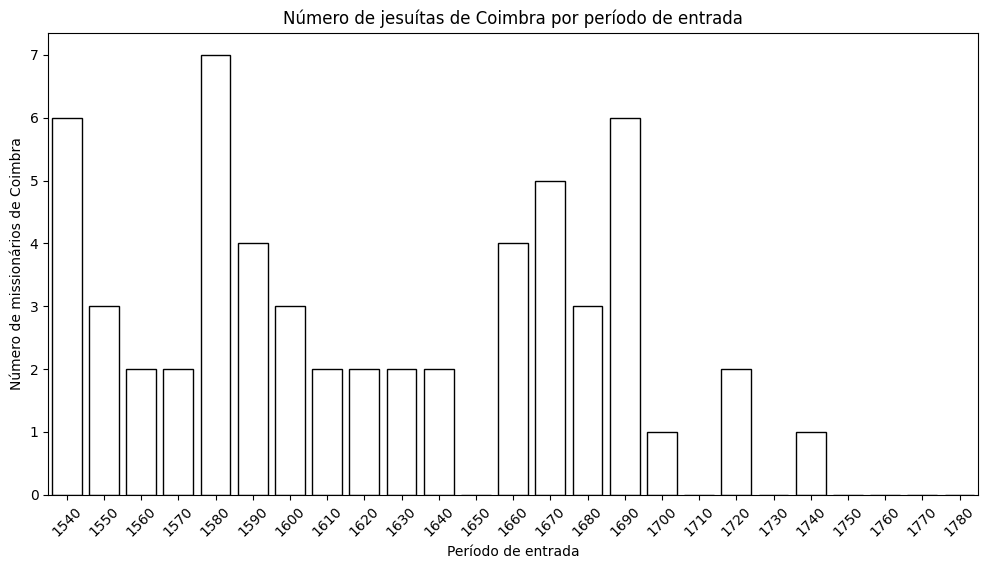

In [37]:
# make a chart of the number of jesuitas-entrada per period ignoring period < 1540
# Label the vertical axis as "Número de missionários de Coimbra"
# Label the horizontal axis as "Período de entrada"
import matplotlib.pyplot as plt
import seaborn as sns

# create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_period_place_of_entry, x='periodo_entrada', y='name', color='white', edgecolor='black')
plt.xticks(rotation=45)
plt.title(f'Número de jesuítas de {place_of_entry} por período de entrada')

# Label the vertical axis
plt.ylabel(f'Número de missionários de {place_of_entry}')

# Label the horizontal axis
plt.xlabel('Período de entrada')

plt.show()

#### Export records to text file

In [38]:
tlnb.db.export_as_kleio(jesuita_entrada_embarque.index.unique(), f"jesuita-entrada-{place_of_entry}.txt")

### Export those with place of entry originally unkown by Dehergne

Added with extra sources

Check those whoose place of entry was originally undertermined in Dehergne.

Those have the notation '%?' in the transcription and in the database, e.g.:

In the Kleio transcript:

         n$Lourenço Mexia/id=deh-lourenco-mexia
            ...
            ls$jesuita-entrada/Coimbra%?# @wikidata:Q45412 Domingues & O Neil, IV: 2645. MMHM:p.226/15600314#ou 15600325 ou Coimbra, 25-03-1560 MMHM
            ...

In the database:

      ls$jesuita-entrada/Coimbra/15600314/obs=
            """
            extra_info: {
                "date": {"comment": "ou 15600325 ou Coimbra, 25-03-1560 MMHM"}, 
                "value": {"comment": "Domingues & O Neil, IV: 2645. MMHM:p.226", 
                           "original": "?"}}
  """

In [39]:
# List rows if '"original": "?"' is in column 'jesuita_entrada.obs'
cols_2 = ['name','jesuita-entrada','jesuita-entrada.date','jesuita-entrada.obs']
place_of_entry_extra = jesuita_entrada_embarque[jesuita_entrada_embarque['jesuita-entrada.obs'].str.contains('"original": "?"', na=False)][cols_2]
place_of_entry_extra_ids = place_of_entry_extra.index.unique()
print("jesuita-entrada through extra info:",len(place_of_entry_extra_ids))
place_of_entry_extra

jesuita-entrada through extra info: 15


,name,jesuita-entrada,jesuita-entrada.date,jesuita-entrada.obs
id,,,,
deh-lourenco-mexia,Lourenço Mexia,Coimbra,15600314,"extra_info: {""date"": {""comment"": ""ou 15600325 ..."
deh-manuel-gaspar,Manuel Gaspar,Coimbra,15750926,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-joao-da-rocha,João da Rocha,Coimbra,15830000,"Corrigido: local de entrada extra_info: {""valu..."
deh-mateus-de-couros,Mateus de Couros,Coimbra,15831222,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-andre-palmeiro,André Palmeiro,Coimbra,15840114,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-manuel-dias-o-novo,"Manuel Dias, o Novo",Coimbra,15930202,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-simao-da-cunha,Simão da Cunha,Coimbra,16060113,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-antonio-de-gouvea,António de Gouveia,Coimbra,16080502,"extra_info: {""date"": {""comment"": ""ou 16090502 ..."
deh-gaspar-do-amaral,Gaspar do Amaral,Coimbra,16080601,"extra_info: {""date"": {""comment"": ""MMHM:p.8""}, ..."


#### Save to Excel

In [40]:
place_of_entry_extra.to_excel(f"jesuita-entrada-{place_of_entry}-extra_info.xlsx", sheet_name=f'jesuita_entrada_{place_of_entry}_extra', index=True)

Make a list

In [41]:
names_list = sorted(list(place_of_entry_extra.name))

# Join the list into a comma-separated string
comma_separated_names = ', '.join(sorted(names_list))

print(comma_separated_names)
names_list

Adriano Pestana, André Ferrão, André Palmeiro, António de Gouveia, Francisco Furtado, Gabriel de Magalhães, Gaspar do Amaral, João da Rocha, Lourenço Mexia, Manuel Dias, o Novo, Manuel Gaspar, Mateus de Couros, Matias da Maia, Sebastião da Maia, Simão da Cunha


['Adriano Pestana',
 'André Ferrão',
 'André Palmeiro',
 'António de Gouveia',
 'Francisco Furtado',
 'Gabriel de Magalhães',
 'Gaspar do Amaral',
 'João da Rocha',
 'Lourenço Mexia',
 'Manuel Dias, o Novo',
 'Manuel Gaspar',
 'Mateus de Couros',
 'Matias da Maia',
 'Sebastião da Maia',
 'Simão da Cunha']

#### export to text file

In [42]:

tlnb.db.export_as_kleio(place_of_entry_extra_ids, f"jesuita-entrada-{place_of_entry}-extra_info.txt")

#### If place of entry unkown check place of entry in the birthplace 

Check for place of interest in the birth place 
of those with no record of place of entry.

Those born in the same city, district or diocesis as the place 
of entry under analysis are good candidates for further research.


In [43]:
# filter dataframe jesuita_entrada_desc for rows with place_of_entry in in column 'nascimento'
maybe = jesuita_entrada_full[jesuita_entrada_full['nascimento'].str.contains(place_of_entry, na=False)].index.unique()
cols=['name','nacionalidade','nascimento','jesuita-entrada.date','jesuita-entrada','jesuita-entrada.obs']
maybe_place_of_entry = jesuita_entrada_full.loc[maybe]
maybe_place_of_entry.info()
maybe_place_of_entry.sort_values(by=['jesuita-entrada.date'])[cols]

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, deh-antonio-lopes-senior to deh-xavier-duarte
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   29 non-null     object
 1   groupname              29 non-null     object
 2   jesuita-entrada.type   29 non-null     object
 3   jesuita-entrada        29 non-null     object
 4   jesuita-entrada.date   29 non-null     object
 5   jesuita-entrada.line   29 non-null     int64 
 6   jesuita-entrada.level  29 non-null     int64 
 7   jesuita-entrada.obs    29 non-null     object
 8   nacionalidade          29 non-null     object
 9   nacionalidade.date     29 non-null     object
 10  nacionalidade.obs      29 non-null     object
 11  nascimento             29 non-null     object
 12  nascimento.date        29 non-null     object
 13  nascimento.obs         29 non-null     object
 14  nacionalidade_sort     29 non-null     obje

,name,nacionalidade,nascimento,jesuita-entrada.date,jesuita-entrada,jesuita-entrada.obs
id,,,,,,
deh-inacio-lobo,Inácio Lobo,Portugal,Coimbra,16240000,?,
deh-jose-estevao-de-almeida,José Estêvão de Almeida,Portugal,"Esgueira, diocese de Coimbra",16280000,?,
deh-antonio-lopes-senior,"António Lopes, sénior",Portugal,"Taveiro, diocese de Coimbra",16310000,?,
deh-inacio-lobo,Inácio Lobo,Portugal,Coimbra,16350000,?,
deh-luis-pinheiro,Luís Pinheiro,Portugal,"Esgueira, diocese de Coimbra",16370000,?,
deh-luis-pinheiro,Luís Pinheiro,Portugal,"Esgueira, diocese de Coimbra",16450000,?,
deh-joao-couceiro,João Couceiro,Portugal,"Tentúgal, diocese de Coimbra",16490000,?,
deh-jose-soares,José Soares,Portugal,"Santa Comba Dão, diocese de Coimbra",16730300,?,"extra_info: {""date"": {""comment"": ""a 15, 23 ou ..."
deh-antonio-simoes-i,António Simões,Portugal,"Rio de Galinhas, diocese de Coimbra",16780000,?,


In [44]:
print("Number of unique ids:", maybe_place_of_entry.index.nunique())

Number of unique ids: 27


Export maybe place of entry candidates

In [45]:
maybe_place_of_entry[cols].to_excel(f"jesuita-entrada-maybe-{place_of_entry}.xlsx", sheet_name=f'jesuita_entrada_maybe_{place_of_entry}', index=True)

Export as text file

In [46]:
tlnb.db.export_as_kleio(maybe_place_of_entry.index.unique(), f"jesuita-entrada-maybe-{place_of_entry}.txt")

 ## Roles and tasks of missionaries from specific place of entry

In [47]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

ids = place_of_entry_ids

roles_tasks = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname',],
    the_type=['jesuita-cargo','jesuita-tarefa'],
    column_name='cargos_tarefas',
    more_attributes=[],
    filter_by=ids,
    db=tlnb.db,
)
# remove rows with "cargos_tarefas" NaN
roles_tasks = roles_tasks.dropna(subset=['cargos_tarefas'])
# extract the year from cargos_tarefas.date
roles_tasks['cargos_tarefas.date.year'] = roles_tasks['cargos_tarefas.date'].str[:4]

roles_tasks.info()
cols=['name','cargos_tarefas','cargos_tarefas.type','cargos_tarefas.date.year','groupname',]
# show those without date
# roles_tasks.loc[roles_tasks['cargos_tarefas.date'] == "0", cols].sort_values(['cargos_tarefas.type','cargos_tarefas','cargos_tarefas.date','name']).head(150)
roles_tasks[cols].sort_values(['cargos_tarefas.type','cargos_tarefas','cargos_tarefas.date.year']).head(150)

<class 'pandas.core.frame.DataFrame'>
Index: 166 entries, deh-francisco-furtado to deh-jose-montanha-ii
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      166 non-null    object 
 1   groupname                 166 non-null    object 
 2   cargos_tarefas.type       166 non-null    object 
 3   cargos_tarefas            166 non-null    object 
 4   cargos_tarefas.date       166 non-null    object 
 5   cargos_tarefas.line       166 non-null    float64
 6   cargos_tarefas.level      166 non-null    float64
 7   cargos_tarefas.obs        166 non-null    object 
 8   cargos_tarefas.date.year  166 non-null    object 
dtypes: float64(2), object(7)
memory usage: 13.0+ KB


,name,cargos_tarefas,cargos_tarefas.type,cargos_tarefas.date.year,groupname
id,,,,,
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1583,n
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1584,n
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1593,n
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1596,n
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1596,n
deh-gaspar-ferreira,Gaspar Ferreira,Mestre dos Noviços,jesuita-cargo,1607,n
deh-lourenco-mexia,Lourenço Mexia,Monitor de Alessandro Valignano,jesuita-cargo,1579,n
deh-jose-montanha-ii,José Montanha,Procurador,jesuita-cargo,1753,n
deh-manuel-gaspar,Manuel Gaspar,Procurador da China e do Japão,jesuita-cargo,1603,n


#### Export to Excel

In [48]:
roles_tasks[cols].to_excel(f"jesuita-entrada-{place_of_entry}-cargos_tarefas.xlsx", sheet_name='cargos_tarefas', index=True)

#### Get start and end dates for roles

In [49]:
roles_start_end = roles_tasks[roles_tasks['cargos_tarefas.type']=='jesuita-cargo'].groupby(['name','cargos_tarefas']).agg(
    start_date=('cargos_tarefas.date.year', 'min'),
    end_date=('cargos_tarefas.date.year', 'max')
).reset_index().sort_values(['name','cargos_tarefas','start_date',])
roles_start_end

,name,cargos_tarefas,start_date,end_date
0,André Palmeiro,Visitador das províncias de Goa e do Malabar,1621,1626
1,André Palmeiro,Visitador das províncias do Malabar,1618,1621
2,André Palmeiro,Visitador do Japão e da China,1626,1635
3,António Gomes,Vice-provincial da China,1748,1751
4,António da Silva,Reitor de Nanquim,1699,1699
5,António da Silva,Socius do bispo de Nanquim,1700,1700
6,António da Silva,Vice-provincial da China,1711,1714
7,António de Andrade,Provincial de Goa,1631,1634
8,António de Andrade,Superior de Agra,1624,1624
9,António de Andrade,Visitador de Agra,1624,1624


##### Save to Excel

In [50]:
roles_start_end.to_excel(f"jesuita-entrada-{place_of_entry}-cargos_tarefas.datas.xlsx", sheet_name='cargos_tarefas', index=True)

#### Filter by role

In [51]:
# filter
regex = "(.*rovincial|.*Visitador|.*Superior|.*Procurador).*(China.*|Japão.*)"
roles_filtered = roles_start_end[roles_start_end.cargos_tarefas.str.contains(regex, na=False)]
roles_filtered.sort_values(['cargos_tarefas', 'start_date'])

/var/folders/x7/qzytnd752559g0w475rfwkx00000gn/T/ipykernel_24129/863054446.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  roles_filtered = roles_start_end[roles_start_end.cargos_tarefas.str.contains(regex, na=False)]


,name,cargos_tarefas,start_date,end_date
45,Manuel Gaspar,Procurador da China e do Japão,1603,1603
47,Manuel Osório,Procurador da Província do Japão em Macau,1705,1705
65,Simão da Cunha,Procurador da Vice-província da China,1648,1658
56,Miguel do Amaral,Procurador da Vice-província da China,1694,1722
26,Francisco Pinto,Procurador do Japão,1717,1717
23,Francisco Pacheco,Provincial do Japão,1621,1625
63,Sebastião da Maia,Provincial do Japão,1646,1649
52,Matias da Maia,Provincial do Japão,1658,1661
57,Miguel do Amaral,Provincial do Japão,1702,1718
27,Francisco Pinto,Provincial do Japão,1705,1710


### Joint biography of entry in Place of interest

In [ ]:
from timelink.pandas import display_group_attributes, group_attributes

ids = place_of_entry_ids

no_show=['jesuita-entrada.level','jesuita-entrada.line','dehergne','estadia@wikidata','jesuita-estatuto',
          'nome','nacionalidade','nascimento@wikidata','nome-chines','titulo','jesuita-entrada@wikidata',
          'jesuita-votos-local@wikidata',
          'wicky','wicky-viagem']

show=['jesuita-entrada','embarque','partida','chegada','estadia','cargo','jesuita-cargo','jesuita-tarefa','morte']
display_group_attributes(ids,
                    entity_type='person',
                    header_elements=['name'],
                    sort_header='jesuita-entrada.date',
                    header_attributes=['jesuita-entrada'],
                    include_attributes=show,
                    exclude_attributes=no_show,
                    sort_attributes=['the_date','the_type','the_value'],
                    db=tlnb.db,
                    category='id',
                    cmap_name='Pastel2'
                    )

## Places of stay / "estadias"

Places of stay: merges different attributes that have localocation as their value





Can filter by places of entry using
the ids saved above in `place_of_entry_ids`

In [74]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

ids = place_of_entry_ids

places_of_stay = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname','the_line','the_order'],
    the_type=['jesuita-entrada','partida','chegada','estadia','estadia-x',
                'jesuita-votos-local','jesuita-ordenacao-padre','morte'],
    column_name='place',
    more_attributes=[],
    # filter_by=ids,
    db=tlnb.db,
)

# fillna with "?"
places_of_stay.place = places_of_stay.place.fillna('?')

# remove rows where place == '?'
places_of_stay = places_of_stay[places_of_stay.place != '?']

# this sequence replaces missing dates with the value of the previous date
# followed by ">". This allows to use the information that although the date
# is unkown it has happened after a certain date
# we need the id in a column to group by it (it is currently in the index)
# TODO: maybe an option in entities_with_attribute and compute intervals using
#       post quem and ante quem dates. See https://github.com/time-link/timelink-kleio/issues/1
places_of_stay['id_col'] = places_of_stay.index
# create a copy of the date column to replace the '0' values with NaN
places_of_stay['place.date_inferred'] = places_of_stay['place.date'].replace('0', pd.NA)
# order by id and line to have the missing date values filled with the previous date
places_of_stay = places_of_stay.sort_values(by=['id_col', 'place.line'])
# use ffill to fill the missing values with the previous value
places_of_stay['place.date_inferred'] = places_of_stay.groupby(['id_col'])['place.date_inferred'].fillna(method='ffill')
# create a column to flag the inferred dates
places_of_stay['place.date_is_inferred'] = places_of_stay['place.date_inferred'] != places_of_stay['place.date']
# reset index
places_of_stay.reset_index(inplace=True)
# if data_is_inferred set date_inferred to date_inferrred+">"
places_of_stay.loc[places_of_stay['place.date_is_inferred'], 'place.date_inferred'] = places_of_stay['place.date_inferred'] + '>'
# set missing value to ''
places_of_stay['place.date_inferred'].fillna('', inplace=True)
# restore index
places_of_stay.index = places_of_stay['id_col']

places_of_stay.info()
# show results
show_only=10
cols=['groupname','name','place.type','place','place.date_inferred','place.date_is_inferred','place.line','place.obs']
places_of_stay[places_of_stay.groupname=='n'][cols].sort_values(by=['place','place.date_inferred']).head(show_only)



<class 'pandas.core.frame.DataFrame'>
Index: 6219 entries, aloys-moriz to simao-rodrigues-ref1
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      6219 non-null   object
 1   name                    6219 non-null   object
 2   groupname               6219 non-null   object
 3   the_line                6219 non-null   int64 
 4   the_order               6219 non-null   int64 
 5   place.type              6219 non-null   object
 6   place                   6219 non-null   object
 7   place.date              6219 non-null   object
 8   place.line              6219 non-null   int64 
 9   place.level             6219 non-null   int64 
 10  place.obs               6219 non-null   object
 11  id_col                  6219 non-null   object
 12  place.date_inferred     6219 non-null   object
 13  place.date_is_inferred  6219 non-null   bool  
dtypes: bool(1), int64(4), object(9)
mem

,groupname,name,place.type,place,place.date_inferred,place.date_is_inferred,place.line,place.obs
id_col,,,,,,,,
deh-charles-francois-xavier-de-brevedent,n,Charles-François Xavier de Brévedent,partida,Abissínia,16980610,False,1339,"extra_info: {""date"": {""comment"": ""pelo Nilo, a..."
deh-antonio-sedeno,n,Antonio Sedeño,estadia,"Acapulco, México",15810329,False,577,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-antoine-rene-de-brasle,n,Antoine-René de Brasle,estadia,"Acapulco, México",17021226>,True,1281,"extra_info: {""value"": {""comment"": ""a caminho d..."
deh-antonio-de-magalhaes,n,António de Magalhães,estadia,Afeganistão,17000000,False,146,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pierre-albier,n,Pierre Albier,jesuita-votos-local,Agen,16540712,False,283,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-philippe-avril,n,Philippe Avril,estadia,Agen,16910000,False,1391,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-bento-de-gois,n,Bento de Góis,estadia,Agra,16021029,False,608,"extra_info: {""date"": {""comment"": ""at\u00e9""}, ..."
deh-antonio-de-andrade,n,António de Andrade,estadia,Agra,16240330,False,1007,"extra_info: {""date"": {""comment"": ""Esteves Pere..."
deh-alano-dos-anjos,n,Alano dos Anjos,estadia,Agra,16360000,False,781,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."


### Save to Excel

In [75]:
places_of_stay[cols].sort_values(by=['place','place.date_inferred']).to_excel(f"jesuita_entrada_places_of_stay.xlsx", sheet_name='no_wikidata', index=True)

#### Export to Excel all unlocated places

In [76]:
places_of_stay[ ~(places_of_stay['place.obs'].str.contains('wikidata', na=False))][cols].sort_values(by=['place','place.date_inferred']).to_excel(f"jesuita_entrada_places_of_stay_no_wikidata.xlsx", sheet_name='no_wikidata', index=True)

#### Only specific place of entry, unkown places

In [77]:
places_of_stay_specific = places_of_stay.loc[place_of_entry_ids]
places_of_stay_specific[~(places_of_stay_specific['place.obs'].str.contains('wikidata', na=False))][cols].sort_values(by=['place','place.date_inferred'])

,groupname,name,place.type,place,place.date_inferred,place.date_is_inferred,place.line,place.obs
id,,,,,,,,
deh-miguel-do-amaral,n,Miguel do Amaral,estadia,"Chengting fou, Hopei",16920000,False,808,
deh-manuel-mendes,n,Manuel Mendes,jesuita-votos-local,Kanchow,16900815,False,1326,
deh-matias-da-maia,n,Matias da Maia,estadia,Kanchow (Kan-tcheou) do Kiangsi,16650000,False,369,
deh-manuel-osorio-i,n,Manuel Osório,partida,"Kanchow, Kiangsi",17000000,False,136,"extra_info: {""date"": {""comment"": ""destinado""}}"
deh-gaspar-ferreira,n,Gaspar Ferreira,estadia,Meiling,16040800,False,681,"extra_info: {""value"": {""comment"": ""a caminho d..."
deh-antonio-de-melo,n,António de Melo,estadia,Tonquim,17250000>,True,1198,"extra_info: {""value"": {""comment"": ""reclam\u00e..."
deh-gaspar-do-amaral,n,Gaspar do Amaral,jesuita-votos-local,Tonquim («in sacello S. J.»),16380106,False,747,
deh-goncalo-alvares,n,Gonçalo Álvares,morte,[A caminho do Japão],15730700,False,702,morre afogado com quatro companheiros no camin...
deh-pedro-martins,n,Pedro Martins,morte,"[No mar, a caminho de Malaca]",15980213,False,819,"extra_info: {""date"": {""comment"": ""=morre de fe..."


In [284]:
places_of_stay_specific[~(places_of_stay_specific['place.obs'].str.contains('wikidata', na=False))][cols].sort_values(by=['place','place.date_inferred']).to_excel(f"jesuita_entrada_{place_of_entry}_places_of_stay_no_wikidata.xlsx", sheet_name='no_wikidata', index=True)

### Frequency of places / Frequência dos lugares

In [285]:
places_of_stay.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6219 entries, aloys-moriz to simao-rodrigues-ref1
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      6219 non-null   object
 1   name                    6219 non-null   object
 2   groupname               6219 non-null   object
 3   the_line                6219 non-null   int64 
 4   the_order               6219 non-null   int64 
 5   place.type              6219 non-null   object
 6   place                   6219 non-null   object
 7   place.date              6219 non-null   object
 8   place.line              6219 non-null   int64 
 9   place.level             6219 non-null   int64 
 10  place.obs               6219 non-null   object
 11  id_col                  6219 non-null   object
 12  place.date_inferred     6219 non-null   object
 13  place.date_is_inferred  6219 non-null   bool  
dtypes: bool(1), int64(4), object(9)
mem

In [286]:
col = 'place' # subtotal by this column

# Use pandas groupby and specify unique value count for id
df_totals = places_of_stay.groupby(col).agg({'id':'nunique',
                                                'place.date_inferred':'min',
                                                'place.date':'max'})
df_totals.info()
df_totals.sort_values('id',ascending= False).head(130)

<class 'pandas.core.frame.DataFrame'>
Index: 1103 entries, Abissínia to Índia Oriental
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   1103 non-null   int64 
 1   place.date_inferred  1103 non-null   object
 2   place.date           1103 non-null   object
dtypes: int64(1), object(2)
memory usage: 34.5+ KB


,id,place.date_inferred,place.date
place,,,
Macau,450,,1773
Pequim,250,,18131213
Goa,209,,17860123
Cantão,197,15550000,17850000
China,180,,18050114
Lisboa,130,,17810300
Roma,111,,18491212
Coimbra,72,15420000,17530000
Paris,65,15270000,17780000


### Place of stay 


List those whose stayed at a specific place



In [287]:
place=place_of_entry # see above

In [293]:
cols = ['place','place.type','place.date_inferred','place.obs']
places_of_stay[places_of_stay.place==place][cols].sort_values(by=['place.date_inferred']).head(show_only)


,place,place.type,place.date_inferred,place.obs
id_col,,,,
deh-pedro-de-alcacova,Coimbra,jesuita-entrada,15420000,"saiu a primeira vez extra_info: {""value"": {""co..."
deh-belchior-nunes-barreto,Coimbra,jesuita-entrada,15430311,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-belchior-miguel-carneiro-leitao,Coimbra,jesuita-entrada,15430425,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-francisco-perez,Coimbra,jesuita-entrada,15440125,"extra_info: {""date"": {""comment"": ""j\u00e1 \u00..."
deh-tiburcio-de-quadros,Coimbra,jesuita-entrada,15440418,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-goncalo-alvares,Coimbra,jesuita-entrada,15490101,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-cristovao-da-costa,Coimbra,jesuita-entrada,15500103,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-joao-rodrigues-de-sainan,Coimbra,jesuita-entrada,15550000,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pedro-martins,Coimbra,jesuita-entrada,15560525,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."


### Geocoding places

Extract wiki data codes

In [64]:
# column "place.obs" has text that in includes strings such as "@wikidata:Q14773"
# define a function that extracts the wikidata id, e.g. Q14773 from column 'place-obs'
# in order to create a new columns, names "wikidata" with the wikidate id
import pandas as pd

def extract_wikidata_id(df):
    df['wikidata'] = df['place.obs'].str.extract(r'@wikidata:(Q\d+)', expand=False)
    return df

places_of_stay = extract_wikidata_id(places_of_stay)
places_of_stay.info()
cols = ['groupname','name','place.type','place','wikidata','place.date_inferred']
places_of_stay[places_of_stay != '?'][cols].sort_values(by=['place']).head(show_only)

<class 'pandas.core.frame.DataFrame'>
Index: 5899 entries, aloys-moriz to simao-rodrigues-ref1
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      5899 non-null   object
 1   name                    5899 non-null   object
 2   groupname               5899 non-null   object
 3   the_line                5899 non-null   int64 
 4   the_order               5899 non-null   int64 
 5   place.type              5899 non-null   object
 6   place                   5899 non-null   object
 7   place.date              5899 non-null   object
 8   place.line              5899 non-null   int64 
 9   place.level             5899 non-null   int64 
 10  place.obs               5899 non-null   object
 11  id_col                  5899 non-null   object
 12  place.date_inferred     5899 non-null   object
 13  place.date_is_inferred  5899 non-null   bool  
 14  wikidata                5058 non-nu

,groupname,name,place.type,place,wikidata,place.date_inferred
id_col,,,,,,
deh-antonio-sedeno,n,Antonio Sedeño,estadia,"Acapulco, México",Q81398,15810329
deh-antonio-de-magalhaes,n,António de Magalhães,estadia,Afeganistão,Q889,17000000
deh-pierre-albier,n,Pierre Albier,jesuita-votos-local,Agen,Q6625,16540712
deh-philippe-avril,n,Philippe Avril,estadia,Agen,Q6625,16910000
deh-albert-le-comte-dorville,n,Albert le Comte Dorville,estadia,Agra,Q42941,16610413>
deh-albert-le-comte-dorville,n,Albert le Comte Dorville,morte,Agra,Q42941,16630408
deh-johann-grueber,n,Johann Grueber,estadia,Agra,Q42941,16620331
deh-bento-de-gois,n,Bento de Góis,estadia,Agra,Q42941,16021029
deh-johann-grueber,n,Johann Grueber,estadia,Agra,Q42941,16620904


#### Missing wikidata

In [65]:
missing_wikidata = places_of_stay[places_of_stay.place != '?']
missing_wikidata = missing_wikidata[missing_wikidata.wikidata.isna()]
missing_wikidata.info()
show_only=10
missing_wikidata[cols].sort_values(by=['place']).head(show_only)

<class 'pandas.core.frame.DataFrame'>
Index: 841 entries, aloys-moriz to joao-cardoso
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      841 non-null    object
 1   name                    841 non-null    object
 2   groupname               841 non-null    object
 3   the_line                841 non-null    int64 
 4   the_order               841 non-null    int64 
 5   place.type              841 non-null    object
 6   place                   841 non-null    object
 7   place.date              841 non-null    object
 8   place.line              841 non-null    int64 
 9   place.level             841 non-null    int64 
 10  place.obs               841 non-null    object
 11  id_col                  841 non-null    object
 12  place.date_inferred     841 non-null    object
 13  place.date_is_inferred  841 non-null    bool  
 14  wikidata                0 non-null      obje

,groupname,name,place.type,place,wikidata,place.date_inferred
id_col,,,,,,
deh-jean-baptiste-regis-mae,mae,Louise de Ferrier,estadia,Aix,NaN,16611127
deh-jean-baptiste-regis-pai,pai,Joseph de Regis,estadia,Aix,NaN,16611127
deh-nicolas-zarate-ref1,referido,Nicéron,estadia,"Amoy, Fukien",NaN,16980000
deh-francisco-gayoso,n,Francisco Gayoso,estadia,"Amoy, Fukien",NaN,16780600
deh-giovanni-laureati,n,Giovanni Laureati,estadia,"Amoy, Fukien",NaN,17020000>
deh-francois-xavier-dentrecolles-ref4,referido,Bernard Rodes,chegada,"Amoy, Fukien",NaN,16990724
deh-nicolas-zarate,n,Nicolás Zárate,estadia,"Amoy, Fukien",NaN,16980000
deh-juan-miguel-de-irigoyen,n,Juan Miguel de Irigoyen,estadia,"Amoy, Fukien",NaN,16780600
deh-jean-baptiste-chambeul-de-champeville,n,Jean-Baptiste Chambeul de Champeville,chegada,"Amoy, Fukien",NaN,17000829


In [291]:

# Use pandas groupby and specify unique value count for id
df_missing_totals = missing_wikidata.groupby(col).agg({'id':'nunique',
                                                'place.date_inferred':'min',
                                                'place.date':'max'})
df_missing_totals.info()
df_missing_totals.sort_values('id',ascending= False).head(130)

<class 'pandas.core.frame.DataFrame'>
Index: 478 entries, Aix to Évora
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   478 non-null    int64 
 1   place.date_inferred  478 non-null    object
 2   place.date           478 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.9+ KB


,id,place.date_inferred,place.date
place,,,
"[No mar, a caminho da China]",30,000000,17500624
Tartária,21,,17890000
"Amoy, Fukien",18,16780600,17000829
Hou-kouang,12,,17690108
"Kiangchow, Shansi",10,16280828,16950000
Soochow,9,16600000,17590000
Kiangsi,9,,17980000
Kiang-si,8,16210000,17480128
Fatshan,7,16810000>,17630000


### Wikidata coordinates

In [ ]:
%pip install pywikibot

In [40]:
import pywikibot

wikidata_id = 'Q10783653'
site = pywikibot.Site("wikidata", "wikidata")
repo = site.data_repository()
item = pywikibot.ItemPage(repo, wikidata_id)
item_dict = item.get()
chinese_label = item_dict['labels']['zh']
english_label = item_dict['labels']['en']
# fetch also the Portuguese label if it exists
portuguese_label = item_dict['labels'].get('pt', None)
# fetch the english description if it exists
english_description = item_dict['descriptions'].get('en', None)
print(chinese_label,english_label, f"({english_description})", portuguese_label)
coord = item_dict['claims']['P625'][0].getTarget()
print(coord.lat, coord.lon)

计策市镇 Kẻ Sặt (thị trấn thuộc huyện Bình Giang) None
20.9167 106.15


## Vows / Votos

In [167]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-votos',
    more_attributes=['jesuita-votos-local','nascimento', 'jesuita-entrada'],
    db=tlnb.db,
)
jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['jesuita-votos-local'] = jesuita_entrada_full['jesuita-votos-local'].fillna('?')
jesuita_entrada_full['jesuita-votos-local'] = jesuita_entrada_full['jesuita-votos-local'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['jesuita-votos-loc-sort'] = jesuita_entrada_full['jesuita-votos-local'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, aloys-moriz to joao-cardoso
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      629 non-null    object
 1   groupname                 629 non-null    object
 2   jesuita-votos.type        629 non-null    object
 3   jesuita-votos             629 non-null    object
 4   jesuita-votos.date        629 non-null    object
 5   jesuita-votos.line        629 non-null    int64 
 6   jesuita-votos.level       629 non-null    int64 
 7   jesuita-votos.obs         629 non-null    object
 8   jesuita-votos-local       529 non-null    object
 9   jesuita-votos-local.date  529 non-null    object
 10  jesuita-votos-local.obs   529 non-null    object
 11  nascimento                604 non-null    object
 12  nascimento.date           604 non-null    object
 13  nascimento.obs            604 non-null    object
 14  jesuita-entr

In [ ]:
# filter dataframe with rows with index in place_of_entry_ids


In [170]:

df = jesuita_entrada_full[jesuita_entrada_full.index.isin(place_of_entry_ids)].copy()
# calculate age at date "jesuita-votos.date" considering "nascimento.date" as date of birth
# and using the function convert_timelink_date to convert the Timelink date to a Python datetime
df['nascimento.date_2'] = df['nascimento.date'].fillna('0').apply(convert_timelink_date)
df['jesuita-votos.date_2'] = df['jesuita-votos.date'].fillna('0').apply(convert_timelink_date)
# calculate diference in years between the two dates
df['age_at_votos'] = df.apply(lambda row: calc_age_at(row['nascimento.date_2'], row['jesuita-votos.date_2']), axis=1)
df['age_at_votos'] = df['age_at_votos'].fillna(0).astype(int)
df[['nascimento.date','jesuita-votos.date','jesuita-votos','age_at_votos']].head(50)


,nascimento.date,jesuita-votos.date,jesuita-votos,age_at_votos
id,,,,
deh-andre-carneiro,16500000,16821208,4V,32
deh-andre-ferrao,16250000,16590116,4V,33
deh-andre-palmeiro,15690000,16030727,4V,34
deh-antao-dantas,16741102,17110815,4V,36
deh-antonio-da-silva,16540113,16870815,4V,33
deh-antonio-de-andrade,15800000,16121014,4V,32
deh-antonio-de-gouvea,15920000,16460714,4V,54
deh-antonio-de-gouvea,15920000,16460714,4V,54
deh-antonio-de-magalhaes,16770000,17110202,4V,33


## Voyages


In [197]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

voyage_of_interest = 23

voyage = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='wicky-viagem',
    the_value=str(voyage_of_interest),
    more_attributes=['chegada','partida','embarque',],
    db=tlnb.db,
)
voyage

,name,groupname,wicky-viagem.type,wicky-viagem,wicky-viagem.date,wicky-viagem.line,wicky-viagem.level,wicky-viagem.obs,chegada,partida,partida.date,partida.obs,embarque,embarque.date,embarque.obs
id,,,,,,,,,,,,,,,
deh-amador-da-costa,Amador da Costa,n,wicky-viagem,23,15760307,1988,4,,None,NaN,NaN,NaN,Sta. Catarina,15760307,"extra_info: {""date"": {""comment"": ""n\u00e3o pad..."
deh-diogo-pinto,Diogo Pinto,n,wicky-viagem,23,15760307,1290,4,,None,NaN,NaN,NaN,Sta. Catarina,15760307,
deh-lourenco-mexia,Lourenço Mexia,n,wicky-viagem,23,15760307,1495,4,,None,Japão,15790707,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Sta. Catarina,15760307,"extra_info: {""value"": {""comment"": ""para Malaca""}}"
deh-lourenco-mexia,Lourenço Mexia,n,wicky-viagem,23,15760307,1495,4,,None,Macau,15820220,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Sta. Catarina,15760307,"extra_info: {""value"": {""comment"": ""para Malaca""}}"


## Other



###  Remover colunas sem valores

---



###  Remove empty columns

In [53]:
jesuita_entrada_embarque.dropna(how='all', axis=1, inplace=True)
jesuita_entrada_embarque.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181 entries, deh-afonso-aires to deh-tome-pereira
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  181 non-null    object
 1   groupname             181 non-null    object
 2   jesuita-entrada       181 non-null    object
 3   jesuita-entrada.date  181 non-null    object
 4   jesuita-entrada.obs   181 non-null    object
 5   nascimento            181 non-null    object
 6   nascimento.date       181 non-null    object
 7   nascimento.obs        181 non-null    object
 8   estadia               176 non-null    object
 9   estadia.date          176 non-null    object
 10  estadia.obs           176 non-null    object
 11  morte                 172 non-null    object
 12  morte.date            172 non-null    object
 13  morte.obs             172 non-null    object
dtypes: object(14)
memory usage: 21.2+ KB


In [54]:
jesuita_entrada_embarque.head(5)

,name,groupname,jesuita-entrada,jesuita-entrada.date,jesuita-entrada.obs,nascimento,nascimento.date,nascimento.obs,estadia,estadia.date,estadia.obs,morte,morte.date,morte.obs
id,,,,,,,,,,,,,,
deh-afonso-aires,Afonso Aires,n,Coimbra,16490000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Santarém,16300000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",NaN,NaN,NaN,"[No mar, depois do Cabo da Boa Esperança]",16570000,
deh-andre-carneiro,André Carneiro,n,Coimbra,16640325,"extra_info: {""date"": {""comment"": ""ou 16630325""...",Porto,16500000,"extra_info: {""date"": {""comment"": ""ou 16480923""...","Chinchinim, Goa",17050000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,17090612,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-antao-dantas,Antão Dantas,n,Coimbra,16930310,"extra_info: {""date"": {""comment"": ""ou 16931016 ...",Porto,16741102,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Macau,17050000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,17210522,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-antao-dantas,Antão Dantas,n,Coimbra,16930310,"extra_info: {""date"": {""comment"": ""ou 16931016 ...",Porto,16741102,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Manila,17070000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,17210522,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-antao-dantas,Antão Dantas,n,Coimbra,16930310,"extra_info: {""date"": {""comment"": ""ou 16931016 ...",Porto,16741102,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Macau,17120000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,17210522,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."



## Contagens

---

## Counting



###  Contagem de atributos a partir de uma tabela em memória

---

###  Count attributes from an existing dataframe



In [43]:
jesuita_entrada_embarque.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, deh-pedro-de-alcacova to deh-inacio-pires
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   name                           57 non-null     object
 1   groupname                      57 non-null     object
 2   jesuita-entrada.type           57 non-null     object
 3   jesuita-entrada                57 non-null     object
 4   jesuita-entrada.date           57 non-null     object
 5   jesuita-entrada.line           57 non-null     int64 
 6   jesuita-entrada.level          57 non-null     int64 
 7   jesuita-entrada.obs            57 non-null     object
 8   dehergne                       57 non-null     object
 9   dehergne.date                  57 non-null     object
 10  dehergne.obs                   57 non-null     object
 11  nascimento                     57 non-null     object
 12  nascimento.date                57 non

In [45]:
# create a column with the index values which are the id numbers
jesuita_entrada_embarque['id'] = jesuita_entrada_embarque.index.values

col = 'jesuita-entrada' # subotal by this column

# Use pandas groupby and specify unique value count for id
df_totals = jesuita_entrada_embarque.groupby(col).agg({'id':'nunique',
                                                  'jesuita-entrada.date':'min',
                                                  'jesuita-entrada.date':'max'})

df_totals.sort_values('id',ascending= False).head(30)

,id,jesuita-entrada.date
jesuita-entrada,,
Coimbra,57,17420427



### Contagens na base de dados

Quando o atributo tem muitos valores e não é necessário
ter todas as pessoas em memória: contagem feita na base de dados

---

### Counting directly in the database
When there are many values and it is not
necessary to have all the people in memory:
count directly in the database.




In [21]:
from timelink.pandas import attribute_values

df_totals = attribute_values('jesuita-entrada',db=tlnb.db)


In [22]:
df_totals.head(10)


,count,date_min,date_max
value,,,
?,512,0,17880828
Coimbra,43,15420000,17420427
Paris,42,15340815,17590310
Lisboa,39,15460000,17521123
Roma,32,15400927,17560709
Goa,30,15480000,17360000
Évora,22,15660714,17460405
Nancy,15,16270929,17510827
Macau,14,16280000,17490201


#### Filtrar por datas

---

#### Filter by dates



In [29]:
df_totals = attribute_values('grau',dates_between=('1535','1600'),db=tlnb.db)

In [30]:
df_totals.head(10)

,count,date_min,date_max
value,,,
Bacharel,9,1554-07-19,1593-06-09
Formatura,6,1574-07-24,1593-05-12
Bacharel em Artes,3,1574-03-14,1588-03-12
Licenciado,3,1574-06-03,1597-05-06
Doutor,2,1560-12-22,1589-10-27
Licenciado em Artes,2,1574-05-15,1589-01-13


## Visualizar registos / View records





### Visualizar uma pessoa / View a person


#### Atributos de uma pessoa numa tabela, uma linha por attributo

---

#### Person attributes in a dataframe, one line per attribute

In [46]:
import pandas as pd
from timelink.pandas import group_attributes as person_attributes

pd.set_option('display.max_rows',1000)

id = 'deh-miguel-do-amaral'
pdf = person_attributes([id],db=tlnb.db)  # note id in a list
pdf[['the_date','the_type','the_value','attr_obs']].sort_values(['the_date','the_type'])

,the_date,the_type,the_value,attr_obs
id,,,,
deh-miguel-do-amaral,0,dehergne,33,"""""""\n Amaral, Miguel do (port) P..."
deh-miguel-do-amaral,0,estadia,Goa,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-miguel-do-amaral,0,estadia,Portugal,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-miguel-do-amaral,0,estadia@wikidata,https://www.wikidata.org/wiki/Q1171,"extra_info: {""value"": {""original"": ""Goa""}}"
deh-miguel-do-amaral,0,estadia@wikidata,https://www.wikidata.org/wiki/Q45,"extra_info: {""value"": {""original"": ""Portugal""}}"
deh-miguel-do-amaral,0,grau-academico,Mestre em Artes,
deh-miguel-do-amaral,0,jesuita-estatuto,Padre,
deh-miguel-do-amaral,0,nacionalidade,Portugal,
deh-miguel-do-amaral,0,nome-chines,Ya Ma-La Eul,"extra_info: {""value"": {""comment"": ""fonetiza\u0..."


In [16]:
p = tlnb.db.get_person(id)
print(p.to_kleio())

n$Adriano Pestana/m/id=deh-adriano-pestana
  ls$nacionalidade/Portugal/0
  ls$jesuita-estatuto/Padre/0
  ls$nascimento@/"https://www.wikidata.org/wiki/Q209036"/16170000
  ls$nascimento/Ilha de S. Miguel, Açores/16170000
  ls$jesuita-entrada/?/16350000
  ls$embarque/?/16430330
  ls$wicky/912/16430330
  ls$wicky-viagem/77/16430330
  ls$estadia@/"https://www.wikidata.org/wiki/Q14773"/16480000
  ls$estadia/Macau (colégio)/16480000
  ls$estadia@/"https://www.wikidata.org/wiki/Q14773"/16540000
  ls$estadia/Macau (colégio)/16540000
  ls$dehergne/631/0/obs="""
      Pestana, Adriano (port.) P. 631 N. Ile S. Miguel, 1617 -E. 1635 (Lus. 44 II, 580). Emb. 30 mars 1643 (W 912)., en 1648 au collège de Macao, mais « pertinet ad vice-provinciam Sinensem » (JS 25, 148), de même en 1654 (JS 25, 161v). M. (n'est plus au catal. de 1660, JS 134, 344)., omis par HS 48.
  """


#### Atributos de uma pessoa numa tabela, attributos em colunas

---

#### Person attributes in a dataframe, attributes in columns

In [39]:
# Get list of people with with a certain value in a specific attribute

id = '316297'  # João Pedro Ribeiro
# id = '234295'  # Alexandre Metelo de Sousa
df = entities_with_attribute(
                    entity_type='person',
                    the_type='uc.entrada',  # we need a base attribute
                    more_info=['name'],
                    more_cols=['instituta','faculdade'],
                    db=tlnb.db,
                    sql_echo=False)
view_cols = ['name','faculdade','faculdade.date','faculdade.obs']
df.info()
df[view_cols].sort_values('faculdade.date')

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 140337 to 269364
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             503 non-null    object
 1   uc.entrada       503 non-null    object
 2   uc.entrada.date  503 non-null    object
 3   uc.entrada.obs   0 non-null      object
 4   instituta        205 non-null    object
 5   instituta.date   205 non-null    object
 6   instituta.obs    205 non-null    object
 7   faculdade        447 non-null    object
 8   faculdade.date   447 non-null    object
 9   faculdade.obs    29 non-null     object
dtypes: object(10)
memory usage: 43.2+ KB


,name,faculdade,faculdade.date,faculdade.obs
id,,,,
140345,Jorge Abenajado,Medicina,1537-12-17,None
140669,Diogo de Abreu,Leis,1538-05-07,None
140347,Adrião de Aboim,Leis,1539-12-07,None
140708,Filipe de Abreu,Cânones,1548-06-23,None
140541,António de Abreu,Cânones,1551-10-00,None
140358,João de Aboim,Cânones,1551-10-01,None
140670,Diogo de Abreu,Leis,1552-07-00,None
140695,Duarte de Abreu,Cânones,1566-01-20,None
140349,António de Aboim,Cânones,1566-12-20,None


#### Examinar potenciais duplicados

---

#### Examine potentital duplicates

In [15]:
from timelink.pandas import display_group_attributes
pd.set_option('display.max_rows',250)

no_show=['código-de-referência','data-do-registo','url','faculdade.ano','naturalidade.ano',
         'matricula-faculdade.ano','nome-apelido','nome-primeiro','nome-geografico.ano',
         'grau.ano','matricula-outra.ano','nome-geografico','instituta.ano']

dup_ids = ['234295','234710',]  # Alexandre Metelo de

display_group_attributes(dup_ids,
                             header_cols=['uc-entrada','naturalidade','faculdade','nome-pai'],
                             exclude_attributes=no_show,
                             sort_attributes=['date','type','value'],
                             cmap_name='Pastel1')

,id,uc-entrada,naturalidade,faculdade,nome-pai
0,234295,1704-11-07,Marialva,Cânones,nan
1,234710,1705-10-24,Marialva,Matemática,Manuel Cardoso Metelo


,date,id,type,value,attr_obs
0,1704-11-07,234295,faculdade,Cânones,Cânones
1,1704-11-07,234295,instituta,1704-11-07,07.11.1704 1704-11-07
2,1704-11-07,234295,naturalidade,Marialva,None
3,1704-11-07,234295,nome,Alexandre Metelo de Sousa,None
4,1704-11-07,234295,uc-entrada,1704-11-07,None
5,1704-11-07,234295,uc-entrada.ano,1704,None
6,1705-10-24,234710,faculdade,Matemática,Matemática
7,1705-10-24,234295,matricula-faculdade,Cânones,24.10.1705
8,1705-10-24,234710,matricula-faculdade,Matemática,24.10.1705
9,1705-10-24,234710,naturalidade,Marialva,None
